In [38]:
from pymongo import MongoClient
import math
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
def divtd(td1, td2):
    us1 = td1.microseconds + 1000000 * (td1.seconds + 86400 * td1.days)
    us2 = td2.microseconds + 1000000 * (td2.seconds + 86400 * td2.days)
    return float(us1) / us2

try:
    import config
    print('using local config file')
    mongodb_uri = config.mongodb_uri
except:
    print('using environment variable')
    mongodb_uri = os.getenv('MONGODB_URI')

using local config file


In [40]:
print("Analyzing Test Data")
success = True

if success:
    try:
        client = MongoClient(mongodb_uri)
        db = client.get_database()
    except Exception as e:
        print('mongo login error ', str(e))
        success = False
if success:
    try:
        dataCursor = db.percentageMove.find(projection={'_id': False},sort=[("timestamp", 1)])
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False
        
if success:
    try:
        df =  pd.DataFrame(list(dataCursor)).set_index(['timestamp'])
        increase = df+1
        cumulative = increase.cumprod(axis=0)
    except Exception as e:
        print('mongo data cursor error ', str(e))
        success = False        
        


Analyzing Test Data


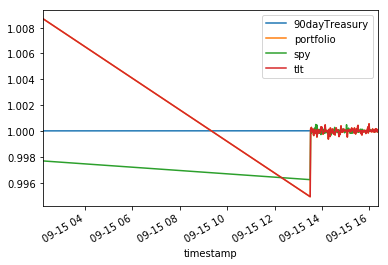

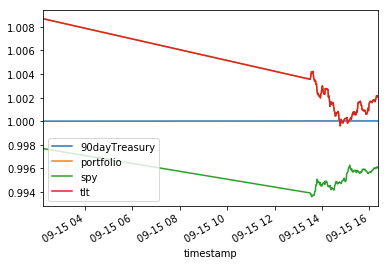

In [41]:
if success:
    plt.figure()
    increase.plot()
    plt.figure()
    cumulative.plot()

In [42]:
if success:
    df['elapsed'] = df.index-df.index[0]
    year = datetime.timedelta(days=365)
    percentageOfYear = divtd((df['elapsed'])[-1], year)
    
    df['spyExcess'] = df['spy']-df['90dayTreasury']
    df['tltExcess'] = df['tlt']-df['90dayTreasury']
    df['portfolioExcess'] = df['portfolio']-df['90dayTreasury']
    df['spyInfoExcess'] = df['portfolio']-df['spy']
    df['tltInfoExcess'] = df['portfolio']-df['tlt']
    print(df['portfolio'])
    
    meanSpyExcess = df['spyExcess'].mean()
    meanTltExcess = df['tltExcess'].mean()
    meanPortfolioExcess = df['portfolioExcess'].mean()
    meanSpyInfoExcess = df['spyInfoExcess'].mean()
    meanTltInfoExcess = df['tltInfoExcess'].mean()
    
    stdSpyExcess = df['spyExcess'].std()
    stdTltExcess = df['tltExcess'].std()
    stdPortfolioExcess = df['portfolioExcess'].std()
    stdSpyInfoExcess = df['spyInfoExcess'].std()
    stdTltInfoExcess = df['tltInfoExcess'].std()
    
    rawSpySharpe = meanSpyExcess/stdSpyExcess
    spySharpe = math.sqrt(len(df.index)/percentageOfYear)*rawSpySharpe
    print('rawSpySharpe = ',rawSpySharpe)
    print('spySharpe = ',spySharpe)
    
    rawTltSharpe = meanTltExcess/stdTltExcess
    tltSharpe = math.sqrt(len(df.index)/percentageOfYear)*rawTltSharpe
    print('\nrawTltSharpe = ',rawTltSharpe)
    print('tltSharpe = ',tltSharpe)
    
    rawPortfolioSharpe = meanPortfolioExcess/stdPortfolioExcess
    portfolioSharpe = math.sqrt(len(df.index)/percentageOfYear)*rawPortfolioSharpe
    print('\nrawPortfolioSharpe = ',rawPortfolioSharpe)
    print('portfolioSharpe = ',portfolioSharpe)
    
    rawSpyInfo = meanSpyInfoExcess/stdSpyInfoExcess
    spyInfo = math.sqrt(len(df.index)/percentageOfYear)*rawSpyInfo
    print('\nrawSpyInfo = ',rawSpyInfo)
    print('spyInfo = ',spyInfo)
    
    rawTltInfo = meanTltInfoExcess/stdTltInfoExcess
    tltInfo = math.sqrt(len(df.index)/percentageOfYear)*rawTltInfo
    print('\nrawTltInfo = ',rawTltInfo)
    print('tltInfo = ',tltInfo)

timestamp
2017-09-15 02:13:17.101    0.008689
2017-09-15 13:30:00.676   -0.005090
2017-09-15 13:31:01.794    0.000157
2017-09-15 13:32:00.931    0.000197
2017-09-15 13:33:00.762    0.000275
2017-09-15 13:34:00.726   -0.000039
2017-09-15 13:35:00.861   -0.000079
2017-09-15 13:36:00.649    0.000000
2017-09-15 13:37:00.712    0.000157
2017-09-15 13:38:00.659   -0.000275
2017-09-15 13:39:00.681   -0.000354
2017-09-15 13:40:00.764   -0.000039
2017-09-15 13:41:00.591   -0.000157
2017-09-15 13:42:00.789   -0.000039
2017-09-15 13:43:00.648    0.000118
2017-09-15 13:44:00.685   -0.000197
2017-09-15 13:45:00.703   -0.000157
2017-09-15 13:46:00.523    0.000039
2017-09-15 13:47:00.475   -0.000472
2017-09-15 13:48:00.711   -0.000276
2017-09-15 13:49:00.553   -0.000158
2017-09-15 13:50:01.196    0.000118
2017-09-15 13:51:00.491   -0.000079
2017-09-15 13:52:00.796   -0.000158
2017-09-15 13:53:00.585    0.000000
2017-09-15 13:54:00.964   -0.000039
2017-09-15 13:55:00.716    0.000039
2017-09-15 13:56:0

ZeroDivisionError: float division by zero